# Time Series Forecasting for Future Sales
---
**Submitted by: Sheetal Bongale | March 2021**

Steps -
1. Data Wrangling and Exploratory Data Analysis
2. Feature Engineering and Selection
3. **Modeling and forecasting**
4. **Model evaluation and validation**
5. **Sales quantity forecast results and visualization**
6. Final results and analysis report

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
from pandas import DataFrame
from pandas import Series
from pandas import concat
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyoff
import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.api as smt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

pio.renderers
pio.renderers.default='notebook+jupyterlab'
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/top_selling_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3814 entries, 0 to 3813
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    3814 non-null   int64  
 1   StockCode    3814 non-null   object 
 2   Description  3814 non-null   object 
 3   Quantity     3814 non-null   int64  
 4   InvoiceDate  3814 non-null   object 
 5   UnitPrice    3814 non-null   float64
 6   CustomerID   3814 non-null   float64
 7   Country      3814 non-null   object 
 8   Year         3814 non-null   int64  
 9   Quarter      3814 non-null   int64  
 10  Month        3814 non-null   int64  
 11  Week         3814 non-null   int64  
 12  Day          3814 non-null   int64  
 13  Weekday      3814 non-null   int64  
 14  Date         3814 non-null   object 
 15  Total_Sales  3814 non-null   float64
dtypes: float64(3), int64(8), object(5)
memory usage: 476.9+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

## EDA

In [4]:
# Duration of dataset
def sales_duration(data):
    data.Date = pd.to_datetime(data.Date)
    number_of_days = data.Date.max() - data.Date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(df)

373 days
1.021917808219178 years


In [5]:
df_sales = df.groupby(['Date'])['Quantity'].sum().reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='teal', label='Total Sales')
    
    second = data.groupby(data.Date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.Date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(365)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()


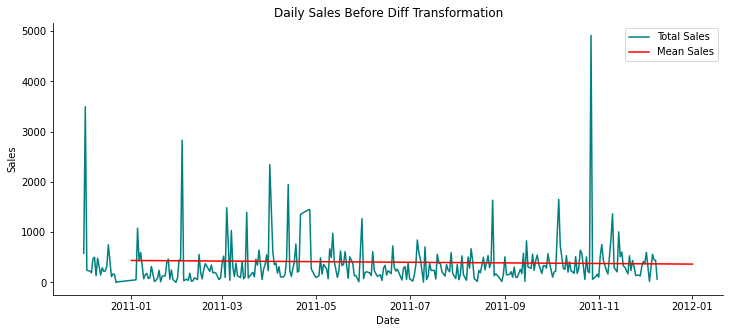

In [7]:
time_plot(df_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

## Item 1: REGENCY CAKESTAND 3 TIER

In [8]:
df1 = df.loc[df['Description']=='REGENCY CAKESTAND 3 TIER']

In [9]:
df1_sales = df1.groupby(['Date'])['Quantity'].sum().reset_index()
df1_sales['Date'] = pd.to_datetime(df1_sales['Date'])

In [10]:
output = adfuller(df1_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -5.96 and p-value: 0.00000


In [11]:
d=1
series_date = df1_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -7.39 and p-value: 0.00000


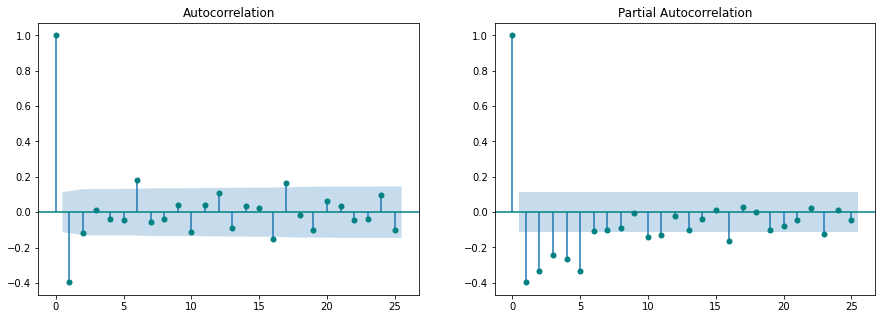

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

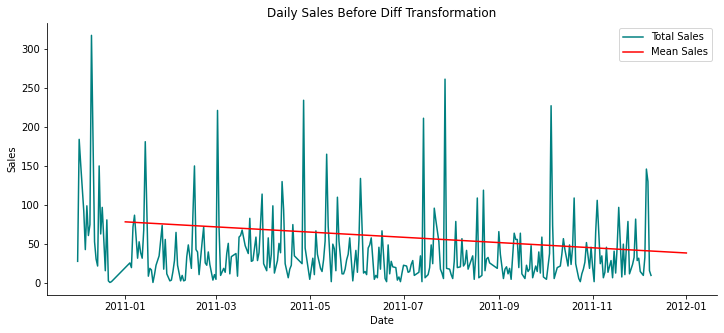

In [13]:
time_plot(df1_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

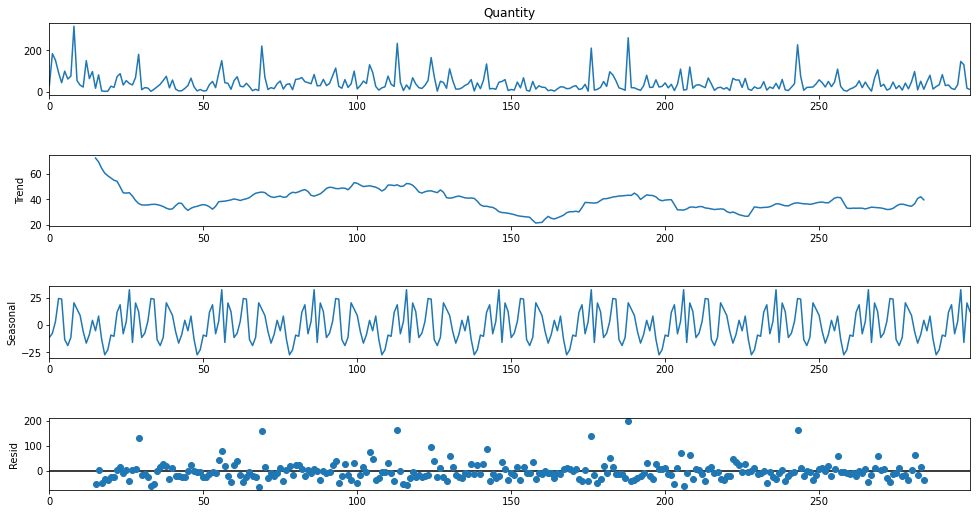

In [14]:
res = sm.tsa.seasonal_decompose(df1_sales.Quantity.dropna(),freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### 1.1 ARIMA - ITEM 1

In [15]:
series_date_1 = df1_sales.Quantity
split_time = 80
time_d = np.arange(len(df1_sales))
xtrain_d = series_date_1[:split_time]
xtest_d = series_date_1[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [16]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                   79
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -439.796
Method:                       css-mle   S.D. of innovations             63.242
Date:                Thu, 18 Mar 2021   AIC                            885.592
Time:                        00:09:57   BIC                            892.700
Sample:                             1   HQIC                           888.440
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.7090      5.084     -0.139      0.889     -10.673       9.255
ar.L1.D.Quantity    -0.4049      0.106     -3.820      0.000      -0.613      -0.197
                            

RMSE Train : 79.50290570106807
RMSE Test : 56.134443583662765


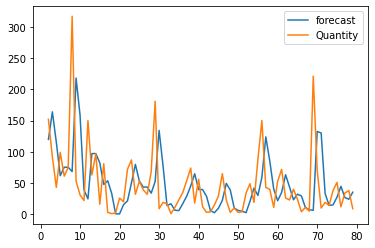

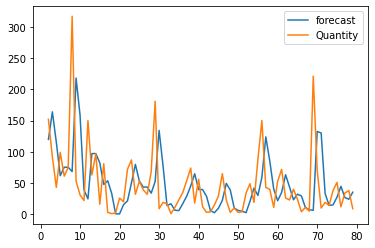

In [17]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [18]:
arima_model_fit.forecast(30)[0]

array([19.74582682, 14.39891231, 15.56780951, 14.09851093, 13.69739499,
       12.86378114, 12.20528195, 11.47588036, 10.77518653, 10.06286918,
        9.35525809,  8.64574147,  7.93699639,  7.22793892,  6.51900793,
        5.81002574,  5.10106427,  4.39209441,  3.68312795,  2.97416012,
        2.26519284,  1.55622534,  0.84725792,  0.13829047, -0.57067696,
       -1.2796444 , -1.98861184, -2.69757928, -3.40654672, -4.11551416])

### 1.2 SARIMA - ITEM 1

In [19]:
model=sm.tsa.statespace.SARIMAX(df1_sales['Quantity'],order=(6, 1, 0),seasonal_order=(6,1,0,12))
results=model.fit()

<AxesSubplot:>

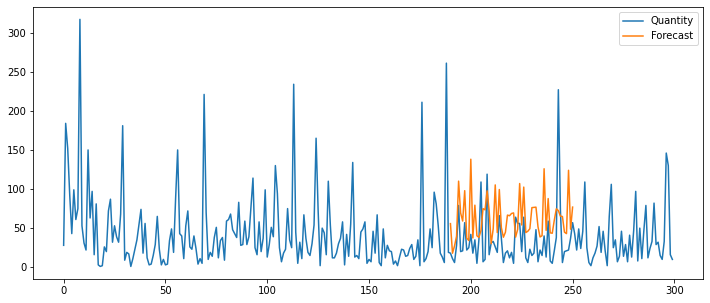

In [21]:
df1_sales['Forecast']=results.predict(start=190,end=250,dynamic=True)
df1_sales[['Quantity','Forecast']].plot(figsize=(12,5))

## Item 2: WORLD WAR 2 GLIDERS ASSTD DESIGNS

In [22]:
df2 = df.loc[df['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']
df2_sales = df2.groupby(['Date'])['Quantity'].sum().reset_index()

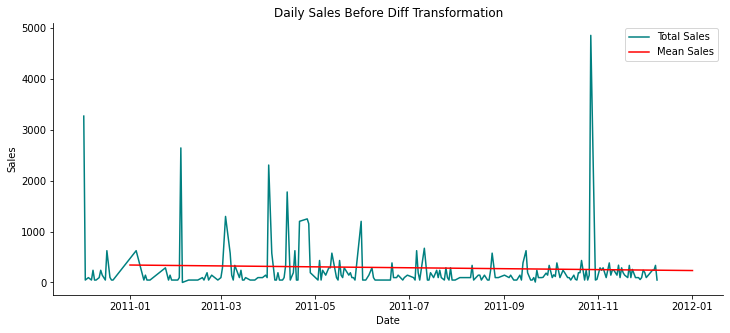

In [23]:
time_plot(df2_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [24]:
output = adfuller(df2_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -16.28 and p-value: 0.00000


In [25]:
d=1
series_date = df2_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -7.92 and p-value: 0.00000


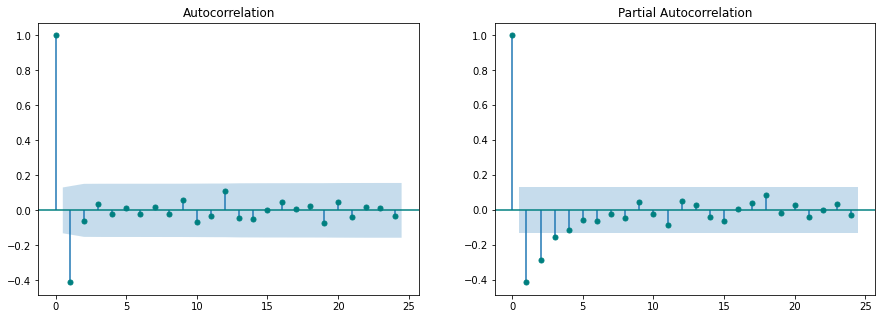

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

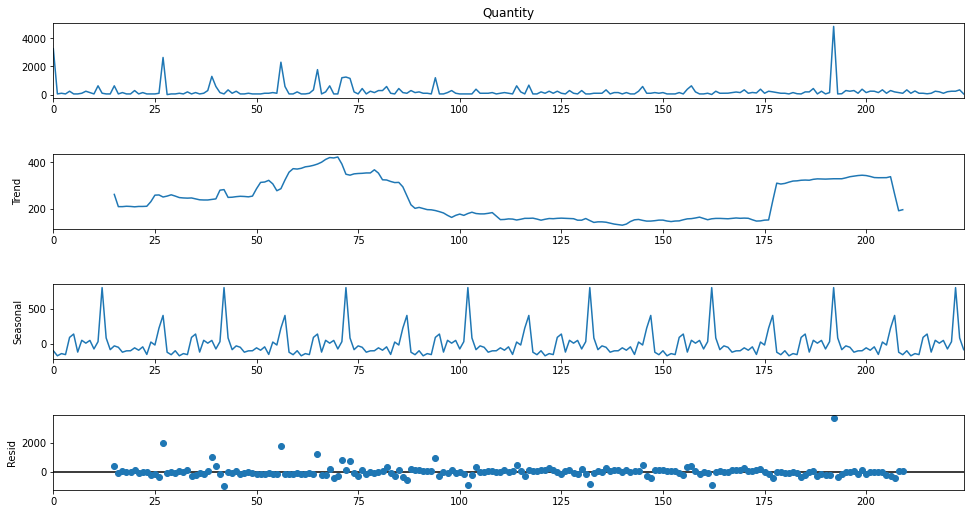

In [27]:
res = sm.tsa.seasonal_decompose(df2_sales.Quantity.dropna(),freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [184]:
series_date_2 = df2_sales.Quantity
split_time = 200
time_d = np.arange(len(df2_sales))
xtrain_d = series_date_2[:split_time]
xtest_d = series_date_2[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [29]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  199
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1563.825
Method:                       css-mle   S.D. of innovations            625.711
Date:                Thu, 18 Mar 2021   AIC                           3133.650
Time:                        00:11:05   BIC                           3143.530
Sample:                             1   HQIC                          3137.649
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -9.8951     30.488     -0.325      0.746     -69.651      49.861
ar.L1.D.Quantity    -0.4573      0.067     -6.794      0.000      -0.589      -0.325
                            

RMSE Train : 631.9566993096558
RMSE Test : 216.53486782635323


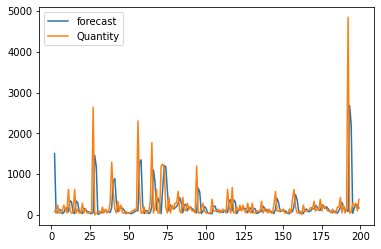

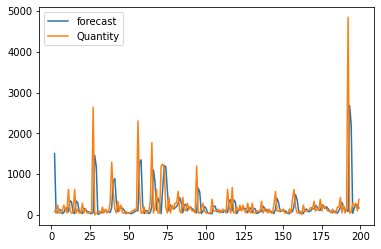

In [30]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [31]:
arima_model_fit.forecast(30)[0]

array([237.87489426, 290.27898279, 251.89394059, 255.0275591 ,
       239.17433223, 232.00395523, 220.86283531, 211.53757073,
       201.38189968, 191.60598075, 181.65639786, 171.78623301,
       161.87974961, 151.98987499, 142.09240503, 132.19840849,
       122.30282352, 112.40796496, 102.5127742 ,  92.61773536,
        82.72262704,  72.8275505 ,  62.93245943,  53.037375  ,
        43.14228753,  33.24720145,  23.35211474,  13.45702832,
         3.56194176,  -6.33314473])

<AxesSubplot:>

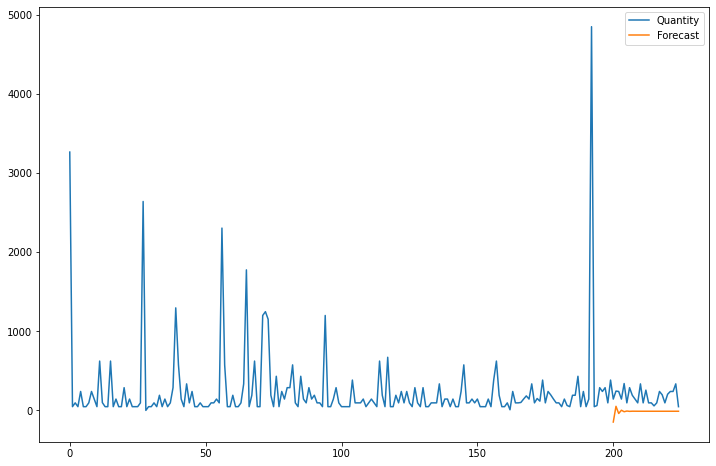

In [32]:
df2_sales['Forecast']=arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)
df2_sales[['Quantity','Forecast']].plot(figsize=(12,8))

### 2.2 SARIMA - ITEM 2

In [33]:
model=sm.tsa.statespace.SARIMAX(df2_sales['Quantity'],order=(1, 1, 0),seasonal_order=(1,1,0,12))
results=model.fit()

<AxesSubplot:>

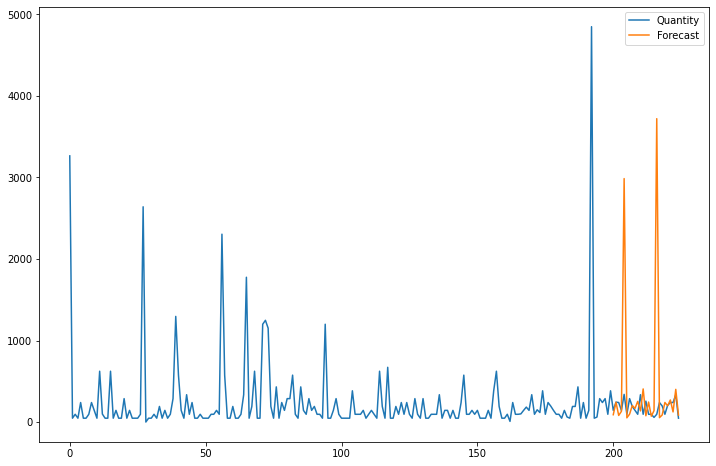

In [34]:
df2_sales['Forecast']=results.predict(start=200,end=224,dynamic=True)
df2_sales[['Quantity','Forecast']].plot(figsize=(12,8))

In [35]:
df2_sales.tail(20)

,Date,Quantity,Forecast
205,2011-11-15,96,52.553494
206,2011-11-16,288,97.669632
207,2011-11-17,192,203.693255
208,2011-11-18,144,168.420793
209,2011-11-20,96,254.190004
210,2011-11-21,336,137.480484
211,2011-11-22,96,406.667397
212,2011-11-23,257,77.717191
213,2011-11-25,96,245.807038
214,2011-11-27,96,72.405501


### 2.1 ARIMA - ITEM 2

## Item 3: JUMBO BAG RED RETROSPOT

In [36]:
df3 = df.loc[df['Description']=='JUMBO BAG RED RETROSPOT']
df3_sales = df3.groupby(['Date'])['Quantity'].sum().reset_index()

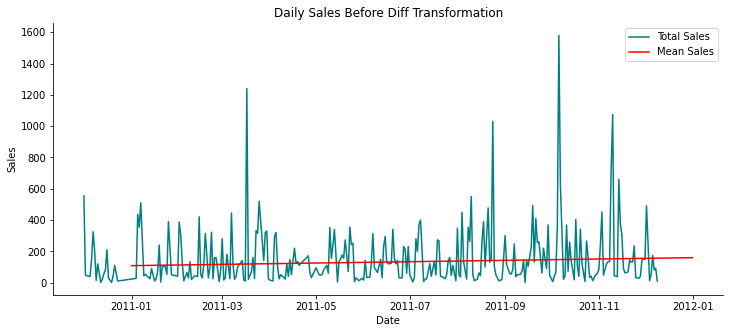

In [37]:
time_plot(df3_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [38]:
output = adfuller(df3_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -12.23 and p-value: 0.00000


In [39]:
d=1
series_date = df3_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -10.25 and p-value: 0.00000


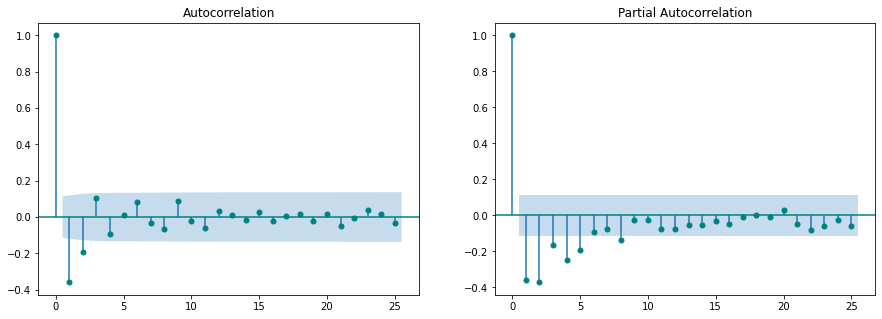

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

In [41]:
resDiff = sm.tsa.arma_order_select_ic(df3_sales['Quantity'], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (1, 1) is the best.


### 3.1 ARIMA - Item 3

In [42]:
series_date_3=df3_sales.Quantity
split_time = 250
time_d=np.arange(len(df3_sales))
xtrain_d=series_date_3[:split_time]
xtest_d=series_date_3[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [43]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  249
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1699.134
Method:                       css-mle   S.D. of innovations            222.418
Date:                Thu, 18 Mar 2021   AIC                           3404.268
Time:                        00:14:15   BIC                           3414.820
Sample:                             1   HQIC                          3408.515
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4703     10.138     -0.046      0.963     -20.340      19.399
ar.L1.D.Quantity    -0.3920      0.059     -6.635      0.000      -0.508      -0.276
                            

RMSE Train : 264.6740458079438
RMSE Test : 274.73765391516315


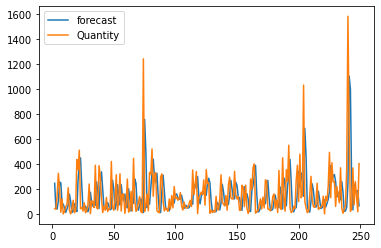

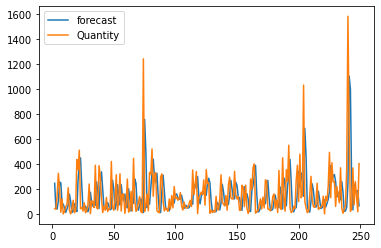

In [44]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=250,end=350,dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [45]:
df3_sales['Forecast'] = ytest_pred

### 3.2 SARIMA - ITEM 3

In [46]:
model=sm.tsa.statespace.SARIMAX(df3_sales['Quantity'],order=(3, 1, 0),seasonal_order=(3,1,0,12))
results=model.fit()

<AxesSubplot:>

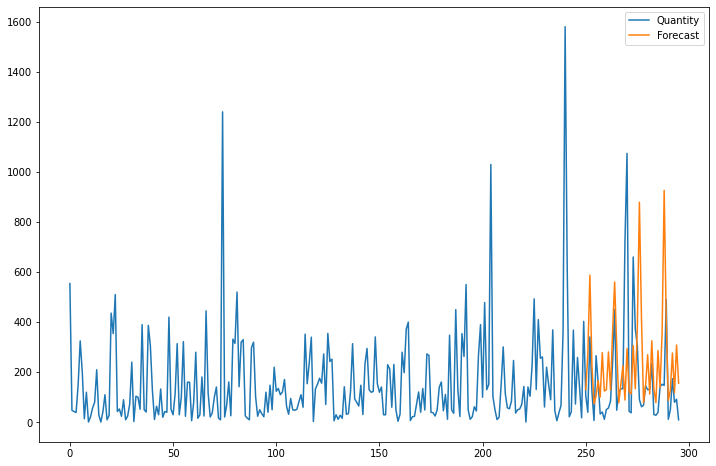

In [47]:
df3_sales['Forecast']=results.predict(start=250,end=350,dynamic=True)
df3_sales[['Quantity','Forecast']].plot(figsize=(12,8))

In [48]:
df3_sales.tail(15)

,Date,Quantity,Forecast
281,2011-11-23,132,112.447558
282,2011-11-24,235,325.429583
283,2011-11-25,31,134.555589
284,2011-11-27,28,78.237329
285,2011-11-28,39,286.230142
286,2011-11-29,141,139.237176
287,2011-11-30,152,355.846711
288,2011-12-01,147,926.246421
289,2011-12-02,490,406.723123
290,2011-12-04,12,86.883111


## LSTM Model - Item 1

In [49]:
df1 = df.loc[df['Description']=='REGENCY CAKESTAND 3 TIER']
df1_sales = df1.groupby(['Date'])['Quantity'].sum().reset_index()
#create a new dataframe to model the difference
df1_diff = df1_sales.copy()
#add previous sales to the next row
df1_diff['Prev_quantity'] = df1_diff['Quantity'].shift(1)
#drop the null values and calculate the difference
df1_diff = df1_diff.dropna()
df1_diff['Diff'] = (df1_diff['Quantity'] - df1_diff['Prev_quantity'])
df1_diff.head(10)

,Date,Quantity,Prev_quantity,Diff
1,2010-12-02,184,28.0,156.0
2,2010-12-03,152,184.0,-32.0
3,2010-12-05,92,152.0,-60.0
4,2010-12-06,43,92.0,-49.0
5,2010-12-07,99,43.0,56.0
6,2010-12-08,61,99.0,-38.0
7,2010-12-09,75,61.0,14.0
8,2010-12-10,317,75.0,242.0
9,2010-12-12,53,317.0,-264.0
10,2010-12-13,31,53.0,-22.0


In [50]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df1_diff['Date'],
        y=df1_diff['Diff'],
        line_color = 'darkturquoise'
    )
]
plot_layout = go.Layout(
        title='Daily Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [51]:
#create dataframe for transformation from time series to supervised
df1_supervised = df1_diff.drop(['Prev_quantity'],axis=1)
#adding lags
for inc in range(1,20):
    field_name = 'lag_' + str(inc)
    df1_supervised[field_name] = df1_supervised['Diff'].shift(inc)
#drop null values
df1_supervised = df1_supervised.dropna().reset_index(drop=True)

In [52]:
df1_supervised.head()

,Date,Quantity,Diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,2011-01-04,26,24.0,1.0,-2.0,-78.0,65.0,-81.0,34.0,-87.0,...,-22.0,-264.0,242.0,14.0,-38.0,56.0,-49.0,-60.0,-32.0,156.0
1,2011-01-05,20,-6.0,24.0,1.0,-2.0,-78.0,65.0,-81.0,34.0,...,-9.0,-22.0,-264.0,242.0,14.0,-38.0,56.0,-49.0,-60.0,-32.0
2,2011-01-06,72,52.0,-6.0,24.0,1.0,-2.0,-78.0,65.0,-81.0,...,128.0,-9.0,-22.0,-264.0,242.0,14.0,-38.0,56.0,-49.0,-60.0
3,2011-01-07,87,15.0,52.0,-6.0,24.0,1.0,-2.0,-78.0,65.0,...,-87.0,128.0,-9.0,-22.0,-264.0,242.0,14.0,-38.0,56.0,-49.0
4,2011-01-09,32,-55.0,15.0,52.0,-6.0,24.0,1.0,-2.0,-78.0,...,34.0,-87.0,128.0,-9.0,-22.0,-264.0,242.0,14.0,-38.0,56.0


In [53]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1', data=df1_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.14929766817848145


In [54]:
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df1_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.41366817995560734


In [55]:
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12 + lag_13 + lag_14 + lag_15 + lag_16 + lag_17 + lag_18 + lag_19 ', data=df1_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.4715046432422719


In [56]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df1_model = df1_supervised.drop(['Quantity','Date'],axis=1)

In [57]:
#split train and test set
train_set, test_set = df1_model[0:-30].values, df1_model[-30:].values

In [58]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [59]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:30]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:30]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [60]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
250/250 [==============================] - 2s 1ms/step - loss: 0.0651
Epoch 2/100
250/250 [==============================] - 0s 958us/step - loss: 0.0630
Epoch 3/100
250/250 [==============================] - 0s 945us/step - loss: 0.0621
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0617
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0614
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0613
Epoch 7/100
250/250 [==============================] - 0s 994us/step - loss: 0.0613
Epoch 8/100
250/250 [==============================] - 0s 984us/step - loss: 0.0612
Epoch 9/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0612
Epoch 10/100
250/250 [==============================] - 0s 940us/step - loss: 0.0612
Epoch 11/100
250/250 [==============================] - 0s 956us/step - loss: 0.0611
Epoch 12/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0611
E

250/250 [==============================] - 0s 1ms/step - loss: 0.0610
Epoch 100/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0610


In [61]:
y_pred = model.predict(X_test,batch_size=1)

In [62]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [63]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[-0.00621889  0.138833    0.22736419 -0.10261569 -0.12676056  0.08249497
  -0.15895372  0.07444668  0.01006036 -0.00201207  0.01408451  0.00192678
  -0.05587669 -0.30635838  0.26011561  0.10211946 -0.07899807  0.12138728
  -0.06358382 -0.03660886]]
[[-0.00794445 -0.35211268  0.138833    0.22736419 -0.10261569 -0.12676056
   0.08249497 -0.15895372  0.07444668  0.01006036 -0.00201207  0.05587669
   0.00192678 -0.05587669 -0.30635838  0.26011561  0.10211946 -0.07899807
   0.12138728 -0.06358382]]
[[-0.00194802  0.01408451 -0.35211268  0.138833    0.22736419 -0.10261569
  -0.12676056  0.08249497 -0.15895372  0.07444668  0.01006036  0.04046243
   0.05587669  0.00192678 -0.05587669 -0.30635838  0.26011561  0.10211946
  -0.07899807  0.12138728]]
[[-0.00723798 -0.138833    0.01408451 -0.35211268  0.138833    0.22736419
  -0.10261569 -0.12676056  0.08249497 -0.15895372  0.07444668  0.05202312
   0.04046243  0.05587669  0.00192678 -0.05587669 -0.30635838  0.26011561
   0.10211946 -0.07899807]]


In [64]:
pred_test_set[0]

array([[-0.00621889,  0.138833  ,  0.22736419, -0.10261569, -0.12676056,
         0.08249497, -0.15895372,  0.07444668,  0.01006036, -0.00201207,
         0.01408451,  0.00192678, -0.05587669, -0.30635838,  0.26011561,
         0.10211946, -0.07899807,  0.12138728, -0.06358382, -0.03660886]])

In [65]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [66]:

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
pred_test_set_inverted

array([[   4.95460498,   41.        ,   63.        ,  -19.        ,
         -25.        ,   27.        ,  -33.        ,   25.        ,
           9.        ,    6.        ,   10.        ,   -4.        ,
         -19.        ,  -84.        ,   63.        ,   22.        ,
         -25.        ,   27.        ,  -21.        ,  -14.        ],
       [   4.52580377,  -81.        ,   41.        ,   63.        ,
         -19.        ,  -25.        ,   27.        ,  -33.        ,
          25.        ,    9.        ,    6.        ,   10.        ,
          -4.        ,  -19.        ,  -84.        ,   63.        ,
          22.        ,  -25.        ,   27.        ,  -21.        ],
       [   6.01591669,   10.        ,  -81.        ,   41.        ,
          63.        ,  -19.        ,  -25.        ,   27.        ,
         -33.        ,   25.        ,    9.        ,    6.        ,
          10.        ,   -4.        ,  -19.        ,  -84.        ,
          63.        ,   22.        ,  -25.   

In [67]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df1_sales[-31:].Date)
act_sales = list(df1_sales[-31:].Quantity)
sales_dates

[Timestamp('2011-11-04 00:00:00'),
 Timestamp('2011-11-06 00:00:00'),
 Timestamp('2011-11-07 00:00:00'),
 Timestamp('2011-11-08 00:00:00'),
 Timestamp('2011-11-09 00:00:00'),
 Timestamp('2011-11-10 00:00:00'),
 Timestamp('2011-11-11 00:00:00'),
 Timestamp('2011-11-13 00:00:00'),
 Timestamp('2011-11-14 00:00:00'),
 Timestamp('2011-11-15 00:00:00'),
 Timestamp('2011-11-16 00:00:00'),
 Timestamp('2011-11-17 00:00:00'),
 Timestamp('2011-11-18 00:00:00'),
 Timestamp('2011-11-20 00:00:00'),
 Timestamp('2011-11-21 00:00:00'),
 Timestamp('2011-11-22 00:00:00'),
 Timestamp('2011-11-23 00:00:00'),
 Timestamp('2011-11-24 00:00:00'),
 Timestamp('2011-11-25 00:00:00'),
 Timestamp('2011-11-27 00:00:00'),
 Timestamp('2011-11-28 00:00:00'),
 Timestamp('2011-11-29 00:00:00'),
 Timestamp('2011-11-30 00:00:00'),
 Timestamp('2011-12-01 00:00:00'),
 Timestamp('2011-12-02 00:00:00'),
 Timestamp('2011-12-04 00:00:00'),
 Timestamp('2011-12-05 00:00:00'),
 Timestamp('2011-12-06 00:00:00'),
 Timestamp('2011-12-

In [68]:
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['Pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df1_result = pd.DataFrame(result_list)

In [69]:
df1_result.tail(10)

,Pred_value,Date
20,39,2011-11-29
21,86,2011-11-30
22,35,2011-12-01
23,38,2011-12-02
24,20,2011-12-04
25,17,2011-12-05
26,38,2011-12-06
27,151,2011-12-07
28,138,2011-12-08
29,23,2011-12-09


In [70]:
df1_sales.head()

,Date,Quantity
0,2010-12-01,28
1,2010-12-02,184
2,2010-12-03,152
3,2010-12-05,92
4,2010-12-06,43


In [71]:

#merge with actual sales dataframe
df1_sales_pred = pd.merge(df1_sales,df1_result,on='Date',how='left')

In [72]:
df1_sales_pred["Item"] = 'REGENCY CAKESTAND 3 TIER'
df1_sales_pred.tail(12)

,Date,Quantity,Pred_value,Item
288,2011-11-27,24,16.0,REGENCY CAKESTAND 3 TIER
289,2011-11-28,33,26.0,REGENCY CAKESTAND 3 TIER
290,2011-11-29,82,39.0,REGENCY CAKESTAND 3 TIER
291,2011-11-30,29,86.0,REGENCY CAKESTAND 3 TIER
292,2011-12-01,32,35.0,REGENCY CAKESTAND 3 TIER
293,2011-12-02,15,38.0,REGENCY CAKESTAND 3 TIER
294,2011-12-04,10,20.0,REGENCY CAKESTAND 3 TIER
295,2011-12-05,33,17.0,REGENCY CAKESTAND 3 TIER
296,2011-12-06,146,38.0,REGENCY CAKESTAND 3 TIER
297,2011-12-07,130,151.0,REGENCY CAKESTAND 3 TIER


In [73]:
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df1_sales_pred['Date'],
        y=df1_sales_pred['Quantity'],
        name='actual',
        line_color = 'darkturquoise'
    ),
        go.Scatter(
        x=df1_sales_pred['Date'],
        y=df1_sales_pred['Pred_value'],
        name='predicted'
    )
    
]

plot_layout = go.Layout(
        title='Sales Forecast'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## LSTM Model - Item 2

In [74]:
df2 = df.loc[df['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']
df2_sales = df2.groupby(['Date'])['Quantity'].sum().reset_index()
#create a new dataframe to model the difference
df2_diff = df2_sales.copy()
#add previous sales to the next row
df2_diff['Prev_quantity'] = df2_diff['Quantity'].shift(1)
#drop the null values and calculate the difference
df2_diff = df2_diff.dropna()
df2_diff['Diff'] = (df2_diff['Quantity'] - df2_diff['Prev_quantity'])
df2_diff.head(10)

,Date,Quantity,Prev_quantity,Diff
1,2010-12-03,48,3264.0,-3216.0
2,2010-12-05,96,48.0,48.0
3,2010-12-07,48,96.0,-48.0
4,2010-12-08,240,48.0,192.0
5,2010-12-09,48,240.0,-192.0
6,2010-12-10,48,48.0,0.0
7,2010-12-12,96,48.0,48.0
8,2010-12-13,240,96.0,144.0
9,2010-12-14,144,240.0,-96.0
10,2010-12-16,48,144.0,-96.0


In [75]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df2_diff['Date'],
        y=df2_diff['Diff'],
        line_color = 'darkturquoise'
    )
]
plot_layout = go.Layout(
        title='Daily Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [76]:
#create dataframe for transformation from time series to supervised
df2_supervised = df2_diff.drop(['Prev_quantity'],axis=1)
#adding lags
for inc in range(1,20):
    field_name = 'lag_' + str(inc)
    df2_supervised[field_name] = df2_supervised['Diff'].shift(inc)
#drop null values
df2_supervised = df2_supervised.dropna().reset_index(drop=True)

In [77]:
df2_supervised.head()

,Date,Quantity,Diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,2011-01-24,288,240.0,0.0,-96.0,96.0,-576.0,576.0,0.0,-51.0,...,-96.0,-96.0,144.0,48.0,0.0,-192.0,192.0,-48.0,48.0,-3216.0
1,2011-01-26,48,-240.0,240.0,0.0,-96.0,96.0,-576.0,576.0,0.0,...,576.0,-96.0,-96.0,144.0,48.0,0.0,-192.0,192.0,-48.0,48.0
2,2011-01-27,144,96.0,-240.0,240.0,0.0,-96.0,96.0,-576.0,576.0,...,-525.0,576.0,-96.0,-96.0,144.0,48.0,0.0,-192.0,192.0,-48.0
3,2011-01-28,48,-96.0,96.0,-240.0,240.0,0.0,-96.0,96.0,-576.0,...,-51.0,-525.0,576.0,-96.0,-96.0,144.0,48.0,0.0,-192.0,192.0
4,2011-01-31,48,0.0,-96.0,96.0,-240.0,240.0,0.0,-96.0,96.0,...,0.0,-51.0,-525.0,576.0,-96.0,-96.0,144.0,48.0,0.0,-192.0


In [78]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1', data=df2_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.20596185556417945


In [79]:
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df2_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.3829410868991041


In [80]:
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12 + lag_13 + lag_14 + lag_15 + lag_16 + lag_17 + lag_18 + lag_19 ', data=df2_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.4380035388715152


In [81]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df2_model = df2_supervised.drop(['Quantity','Date'],axis=1)

In [82]:
#split train and test set
train_set, test_set = df2_model[0:-30].values, df2_model[-30:].values

In [83]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [84]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:30]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:30]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [85]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
175/175 [==============================] - 1s 1ms/step - loss: 0.0568
Epoch 2/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0552
Epoch 3/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 4/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 5/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0542
Epoch 6/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 7/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 8/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0539
Epoch 9/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch 10/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch 11/100
175/175 [==============================] - 0s 945us/step - loss: 0.0538
Epoch 12/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0537
Epoch 13/10

175/175 [==============================] - 0s 1ms/step - loss: 0.0536
Epoch 100/100
175/175 [==============================] - 0s 1ms/step - loss: 0.0536


In [86]:
y_pred = model.predict(X_test,batch_size=1)

In [89]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [90]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 1.98676437e-02  1.30471380e-02 -1.58858777e+00  1.83349412e+00
   5.53733359e-02 -5.57592128e-02  9.24175188e-02 -1.29847579e-01
   1.10939610e-01  1.83291530e-02  7.38954274e-02  1.25409994e-02
  -1.29268763e-02  5.53733359e-02 -1.92938453e-04  1.83291530e-02
  -1.92938453e-04 -1.73644607e-03  1.35056917e-03  1.66666667e-01]]
[[-3.45556997e-02  5.76599327e-02 -2.77407054e-01 -1.83387999e+00
   1.83349412e+00  5.53733359e-02 -5.57592128e-02  9.24175188e-02
  -1.29847579e-01  1.10939610e-01  1.83291530e-02  7.38954274e-02
   1.25409994e-02 -1.29268763e-02  5.53733359e-02 -1.92938453e-04
   1.83291530e-02 -1.92938453e-04 -1.73644607e-03  1.01388889e-01]]
[[-2.15273276e-02  6.59194921e-17 -2.19664987e-01  2.37314297e-02
  -1.83387999e+00  1.83349412e+00  5.53733359e-02 -5.57592128e-02
   9.24175188e-02 -1.29847579e-01  1.10939610e-01  1.83291530e-02
   7.38954274e-02  1.25409994e-02 -1.29268763e-02  5.53733359e-02
  -1.92938453e-04  1.83291530e-02 -1.92938453e-04  9.86111111e-02]]
[[-7

In [91]:
pred_test_set[0]

array([[ 1.98676437e-02,  1.30471380e-02, -1.58858777e+00,
         1.83349412e+00,  5.53733359e-02, -5.57592128e-02,
         9.24175188e-02, -1.29847579e-01,  1.10939610e-01,
         1.83291530e-02,  7.38954274e-02,  1.25409994e-02,
        -1.29268763e-02,  5.53733359e-02, -1.92938453e-04,
         1.83291530e-02, -1.92938453e-04, -1.73644607e-03,
         1.35056917e-03,  1.66666667e-01]])

In [92]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [93]:

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
pred_test_set_inverted

array([[ 4.64110429e+01,  1.40000000e+01, -4.80000000e+03,
         4.70400000e+03,  9.60000000e+01, -1.92000000e+02,
         1.92000000e+02, -3.84000000e+02,  2.40000000e+02,
         0.00000000e+00,  1.44000000e+02, -1.50000000e+01,
        -8.10000000e+01,  9.60000000e+01, -4.80000000e+01,
         0.00000000e+00, -4.80000000e+01, -5.20000000e+01,
        -4.40000000e+01,  1.44000000e+02],
       [-2.12208685e+02,  2.26000000e+02,  1.40000000e+01,
        -4.80000000e+03,  4.70400000e+03,  9.60000000e+01,
        -1.92000000e+02,  1.92000000e+02, -3.84000000e+02,
         2.40000000e+02,  0.00000000e+00,  1.44000000e+02,
        -1.50000000e+01, -8.10000000e+01,  9.60000000e+01,
        -4.80000000e+01,  0.00000000e+00, -4.80000000e+01,
        -5.20000000e+01, -4.40000000e+01],
       [-1.50297861e+02, -4.80000000e+01,  2.26000000e+02,
         1.40000000e+01, -4.80000000e+03,  4.70400000e+03,
         9.60000000e+01, -1.92000000e+02,  1.92000000e+02,
        -3.84000000e+02,  2.4

In [94]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df2_sales[-31:].Date)
act_sales = list(df2_sales[-31:].Quantity)
sales_dates

[Timestamp('2011-10-31 00:00:00'),
 Timestamp('2011-11-02 00:00:00'),
 Timestamp('2011-11-03 00:00:00'),
 Timestamp('2011-11-04 00:00:00'),
 Timestamp('2011-11-06 00:00:00'),
 Timestamp('2011-11-08 00:00:00'),
 Timestamp('2011-11-09 00:00:00'),
 Timestamp('2011-11-10 00:00:00'),
 Timestamp('2011-11-11 00:00:00'),
 Timestamp('2011-11-13 00:00:00'),
 Timestamp('2011-11-14 00:00:00'),
 Timestamp('2011-11-15 00:00:00'),
 Timestamp('2011-11-16 00:00:00'),
 Timestamp('2011-11-17 00:00:00'),
 Timestamp('2011-11-18 00:00:00'),
 Timestamp('2011-11-20 00:00:00'),
 Timestamp('2011-11-21 00:00:00'),
 Timestamp('2011-11-22 00:00:00'),
 Timestamp('2011-11-23 00:00:00'),
 Timestamp('2011-11-25 00:00:00'),
 Timestamp('2011-11-27 00:00:00'),
 Timestamp('2011-11-28 00:00:00'),
 Timestamp('2011-11-29 00:00:00'),
 Timestamp('2011-11-30 00:00:00'),
 Timestamp('2011-12-01 00:00:00'),
 Timestamp('2011-12-02 00:00:00'),
 Timestamp('2011-12-05 00:00:00'),
 Timestamp('2011-12-06 00:00:00'),
 Timestamp('2011-12-

In [95]:
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['Pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df2_result = pd.DataFrame(result_list)

In [97]:
df2_sales.head()

,Date,Quantity
0,2010-12-02,3264
1,2010-12-03,48
2,2010-12-05,96
3,2010-12-07,48
4,2010-12-08,240


In [98]:

#merge with actual sales dataframe
df2_sales_pred = pd.merge(df2_sales,df2_result,on='Date',how='left')

In [99]:
df2_sales_pred["Item"] = 'WORLD WAR 2 GLIDERS ASSTD DESIGNS'
df2_sales_pred.tail(11)

,Date,Quantity,Pred_value,Item
214,2011-11-27,96,75.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
215,2011-11-28,58,85.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
216,2011-11-29,96,38.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
217,2011-11-30,240,87.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
218,2011-12-01,198,239.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
219,2011-12-02,96,183.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
220,2011-12-05,205,110.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
221,2011-12-06,240,194.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
222,2011-12-07,240,246.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
223,2011-12-08,336,240.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS


In [100]:
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df2_sales_pred['Date'],
        y=df2_sales_pred['Quantity'],
        name='actual',
        line_color = 'darkturquoise'
    ),
        go.Scatter(
        x=df2_sales_pred['Date'],
        y=df2_sales_pred['Pred_value'],
        name='predicted'
    )
    
]

plot_layout = go.Layout(
        title='Sales Forecast'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## LSTM Model - Item 3

In [189]:
df3 = df.loc[df['Description']=='JUMBO BAG RED RETROSPOT']
df3_sales = df3.groupby(['Date'])['Quantity'].sum().reset_index()
#create a new dataframe to model the difference
df3_diff = df3_sales.copy()
#add previous sales to the next row
df3_diff['Prev_quantity'] = df3_diff['Quantity'].shift(1)
#drop the null values and calculate the difference
df3_diff = df3_diff.dropna()
df3_diff['Diff'] = (df3_diff['Quantity'] - df3_diff['Prev_quantity'])
df3_diff.head(10)

,Date,Quantity,Prev_quantity,Diff
1,2010-12-02,48,554.0,-506.0
2,2010-12-03,43,48.0,-5.0
3,2010-12-05,39,43.0,-4.0
4,2010-12-06,149,39.0,110.0
5,2010-12-07,325,149.0,176.0
6,2010-12-08,201,325.0,-124.0
7,2010-12-09,14,201.0,-187.0
8,2010-12-10,120,14.0,106.0
9,2010-12-12,1,120.0,-119.0
10,2010-12-13,22,1.0,21.0


In [190]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df3_diff['Date'],
        y=df3_diff['Diff'],
        line_color = 'darkturquoise'
    )
]
plot_layout = go.Layout(
        title='Daily Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [191]:
#create dataframe for transformation from time series to supervised
df3_supervised = df3_diff.drop(['Prev_quantity'],axis=1)
#adding lags
for inc in range(1,20):
    field_name = 'lag_' + str(inc)
    df3_supervised[field_name] = df3_supervised['Diff'].shift(inc)
#drop null values
df3_supervised = df3_supervised.dropna().reset_index(drop=True)

In [192]:
df3_supervised.head()

,Date,Quantity,Diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,2011-01-05,436,409.0,17.0,-100.0,68.0,41.0,-29.0,-180.0,130.0,...,21.0,-119.0,106.0,-187.0,-124.0,176.0,110.0,-4.0,-5.0,-506.0
1,2011-01-06,354,-82.0,409.0,17.0,-100.0,68.0,41.0,-29.0,-180.0,...,35.0,21.0,-119.0,106.0,-187.0,-124.0,176.0,110.0,-4.0,-5.0
2,2011-01-07,510,156.0,-82.0,409.0,17.0,-100.0,68.0,41.0,-29.0,...,23.0,35.0,21.0,-119.0,106.0,-187.0,-124.0,176.0,110.0,-4.0
3,2011-01-09,43,-467.0,156.0,-82.0,409.0,17.0,-100.0,68.0,41.0,...,130.0,23.0,35.0,21.0,-119.0,106.0,-187.0,-124.0,176.0,110.0
4,2011-01-10,53,10.0,-467.0,156.0,-82.0,409.0,17.0,-100.0,68.0,...,-180.0,130.0,23.0,35.0,21.0,-119.0,106.0,-187.0,-124.0,176.0


In [193]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1', data=df3_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.1319219522851085


In [194]:
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df3_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.3420107964215656


In [195]:
# Define the regression formula
model = smf.ols(formula='Diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12 + lag_13 + lag_14 + lag_15 + lag_16 + lag_17 + lag_18 + lag_19 ', data=df3_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.3664622595732915


In [196]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df3_model = df3_supervised.drop(['Quantity','Date'],axis=1)

In [197]:
#split train and test set
train_set, test_set = df3_model[0:-30].values, df3_model[-30:].values

In [198]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [199]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:30]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:30]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [200]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
246/246 [==============================] - 2s 1ms/step - loss: 0.0341
Epoch 2/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 3/100
246/246 [==============================] - 0s 964us/step - loss: 0.0319
Epoch 4/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 5/100
246/246 [==============================] - 0s 991us/step - loss: 0.0316
Epoch 6/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 7/100
246/246 [==============================] - 0s 958us/step - loss: 0.0315
Epoch 8/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 9/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 10/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 11/100
246/246 [==============================] - 0s 966us/step - loss: 0.0315
Epoch 12/100
246/246 [==============================] - 0s 984us/step - loss: 0.0315
Epo

246/246 [==============================] - 0s 1ms/step - loss: 0.0314A: 0s - loss: 0.
Epoch 99/100
246/246 [==============================] - 0s 1ms/step - loss: 0.0314
Epoch 100/100
246/246 [==============================] - 0s 965us/step - loss: 0.0314


In [202]:
y_pred = model.predict(X_test,batch_size=1)


In [207]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
scores

1/1 [==============================] - 0s 18ms/step - loss: 0.0571


0.05713725835084915

In [116]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [117]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.00256181 -0.33360555  0.16945692  0.12127399  0.01755819  0.00040833
   0.02735811 -0.02817477  0.00204165 -0.10820743 -0.09105757  0.20702327
  -0.09840751 -0.18334014  0.24132299 -0.05920784 -0.24622295  0.30992242
  -0.10494079 -0.10085749]]
[[-0.00233213  0.05430788 -0.33360555  0.16945692  0.12127399  0.01755819
   0.00040833  0.02735811 -0.02817477  0.00204165 -0.10820743 -0.09105757
   0.20702327 -0.09840751 -0.18334014  0.24132299 -0.05920784 -0.24622295
   0.30992242 -0.10494079]]
[[-0.0021806   0.00694161  0.05430788 -0.33360555  0.16945692  0.12127399
   0.01755819  0.00040833  0.02735811 -0.02817477  0.00204165 -0.10820743
  -0.09105757  0.20702327 -0.09840751 -0.18334014  0.24132299 -0.05920784
  -0.24622295  0.30992242]]
[[-0.00396166 -0.00449163  0.00694161  0.05430788 -0.33360555  0.16945692
   0.12127399  0.01755819  0.00040833  0.02735811 -0.02817477  0.00204165
  -0.10820743 -0.09105757  0.20702327 -0.09840751 -0.18334014  0.24132299
  -0.05920784 -0.24622295]]


In [118]:
pred_test_set[0]

array([[ 0.00256181, -0.33360555,  0.16945692,  0.12127399,  0.01755819,
         0.00040833,  0.02735811, -0.02817477,  0.00204165, -0.10820743,
        -0.09105757,  0.20702327, -0.09840751, -0.18334014,  0.24132299,
        -0.05920784, -0.24622295,  0.30992242, -0.10494079, -0.10085749]])

In [119]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [120]:

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
pred_test_set_inverted

array([[ 8.63693630e+00, -4.03000000e+02,  2.13000000e+02,
         1.54000000e+02,  2.70000000e+01,  6.00000000e+00,
         3.90000000e+01, -2.90000000e+01,  8.00000000e+00,
        -1.27000000e+02, -1.06000000e+02,  2.59000000e+02,
        -1.15000000e+02, -2.19000000e+02,  3.01000000e+02,
        -6.70000000e+01, -2.96000000e+02,  3.85000000e+02,
        -1.23000000e+02, -1.18000000e+02],
       [ 2.64431026e+00,  7.20000000e+01, -4.03000000e+02,
         2.13000000e+02,  1.54000000e+02,  2.70000000e+01,
         6.00000000e+00,  3.90000000e+01, -2.90000000e+01,
         8.00000000e+00, -1.27000000e+02, -1.06000000e+02,
         2.59000000e+02, -1.15000000e+02, -2.19000000e+02,
         3.01000000e+02, -6.70000000e+01, -2.96000000e+02,
         3.85000000e+02, -1.23000000e+02],
       [ 2.82985293e+00,  1.40000000e+01,  7.20000000e+01,
        -4.03000000e+02,  2.13000000e+02,  1.54000000e+02,
         2.70000000e+01,  6.00000000e+00,  3.90000000e+01,
        -2.90000000e+01,  8.0

In [121]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df3_sales[-31:].Date)
act_sales = list(df3_sales[-31:].Quantity)

[Timestamp('2011-11-04 00:00:00'),
 Timestamp('2011-11-06 00:00:00'),
 Timestamp('2011-11-07 00:00:00'),
 Timestamp('2011-11-08 00:00:00'),
 Timestamp('2011-11-09 00:00:00'),
 Timestamp('2011-11-10 00:00:00'),
 Timestamp('2011-11-11 00:00:00'),
 Timestamp('2011-11-13 00:00:00'),
 Timestamp('2011-11-14 00:00:00'),
 Timestamp('2011-11-15 00:00:00'),
 Timestamp('2011-11-16 00:00:00'),
 Timestamp('2011-11-17 00:00:00'),
 Timestamp('2011-11-18 00:00:00'),
 Timestamp('2011-11-20 00:00:00'),
 Timestamp('2011-11-21 00:00:00'),
 Timestamp('2011-11-22 00:00:00'),
 Timestamp('2011-11-23 00:00:00'),
 Timestamp('2011-11-24 00:00:00'),
 Timestamp('2011-11-25 00:00:00'),
 Timestamp('2011-11-27 00:00:00'),
 Timestamp('2011-11-28 00:00:00'),
 Timestamp('2011-11-29 00:00:00'),
 Timestamp('2011-11-30 00:00:00'),
 Timestamp('2011-12-01 00:00:00'),
 Timestamp('2011-12-02 00:00:00'),
 Timestamp('2011-12-04 00:00:00'),
 Timestamp('2011-12-05 00:00:00'),
 Timestamp('2011-12-06 00:00:00'),
 Timestamp('2011-12-

In [122]:
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['Pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Date'] = sales_dates[index+1]
    result_list.append(result_dict)
df3_result = pd.DataFrame(result_list)

In [124]:
df3_sales.head()

,Date,Quantity
0,2010-12-01,554
1,2010-12-02,48
2,2010-12-03,43
3,2010-12-05,39
4,2010-12-06,149


In [125]:

#merge with actual sales dataframe
df3_sales_pred = pd.merge(df3_sales,df3_result,on='Date',how='left')

In [126]:
df3_sales_pred["Item"] = 'JUMBO BAG RED RETROSPOT'
df3_sales_pred.tail(12)

,Date,Quantity,Pred_value,Item
284,2011-11-27,28,3.0,JUMBO BAG RED RETROSPOT
285,2011-11-28,39,38.0,JUMBO BAG RED RETROSPOT
286,2011-11-29,141,32.0,JUMBO BAG RED RETROSPOT
287,2011-11-30,152,166.0,JUMBO BAG RED RETROSPOT
288,2011-12-01,147,138.0,JUMBO BAG RED RETROSPOT
289,2011-12-02,490,138.0,JUMBO BAG RED RETROSPOT
290,2011-12-04,12,438.0,JUMBO BAG RED RETROSPOT
291,2011-12-05,50,32.0,JUMBO BAG RED RETROSPOT
292,2011-12-06,174,66.0,JUMBO BAG RED RETROSPOT
293,2011-12-07,80,159.0,JUMBO BAG RED RETROSPOT


In [127]:
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df3_sales_pred['Date'],
        y=df3_sales_pred['Quantity'],
        name='actual',
        line_color = 'darkturquoise'
    ),
        go.Scatter(
        x=df3_sales_pred['Date'],
        y=df3_sales_pred['Pred_value'],
        name='predicted'
    )
    
]

plot_layout = go.Layout(
        title='Sales Forecast'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [187]:
pdList = [df1_sales_pred.tail(12), df2_sales_pred.tail(12), df3_sales_pred.tail(12)]  
lstm_df = pd.concat(pdList)
lstm_df

,Date,Quantity,Pred_value,Item
288,2011-11-27,24,16.0,REGENCY CAKESTAND 3 TIER
289,2011-11-28,33,26.0,REGENCY CAKESTAND 3 TIER
290,2011-11-29,82,39.0,REGENCY CAKESTAND 3 TIER
291,2011-11-30,29,86.0,REGENCY CAKESTAND 3 TIER
292,2011-12-01,32,35.0,REGENCY CAKESTAND 3 TIER
293,2011-12-02,15,38.0,REGENCY CAKESTAND 3 TIER
294,2011-12-04,10,20.0,REGENCY CAKESTAND 3 TIER
295,2011-12-05,33,17.0,REGENCY CAKESTAND 3 TIER
296,2011-12-06,146,38.0,REGENCY CAKESTAND 3 TIER
297,2011-12-07,130,151.0,REGENCY CAKESTAND 3 TIER


In [188]:
lstm_df.to_csv("../data/LSTM_results.csv",index=None)

## PROPHET

In [130]:
import pystan
import fbprophet
from fbprophet import Prophet
from pandas import to_datetime
from matplotlib import pyplot
from scipy.stats import boxcox

In [131]:
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


### PROPHET - Item 1

In [132]:
df1_item = df.loc[df['Description']=='REGENCY CAKESTAND 3 TIER']
df1p = df1_item.groupby(['Date'])['Quantity'].sum().reset_index()
df1p

,Date,Quantity
0,2010-12-01,28
1,2010-12-02,184
2,2010-12-03,152
3,2010-12-05,92
4,2010-12-06,43
...,...,...
295,2011-12-05,33
296,2011-12-06,146
297,2011-12-07,130
298,2011-12-08,16


In [133]:
df1p['ds'] = df1p['Date']
df1p['y'] = df1p['Quantity']
df1p['ds']= to_datetime(df1p['ds'])

In [134]:
## Since our time series data is not stationary, one nifty workaround is using a box cox transformation to 
# transform the data and then apply our forecasting technique. 

from scipy.stats import boxcox
df1p['y_orig'] = df1p['y']
df1p['y'], lam = boxcox(df1p['y'])

In [135]:
# define the model
model = Prophet()
model.add_country_holidays(country_name = 'US')
# fit the model
model.fit(df1p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [136]:
future = model.make_future_dataframe(periods=5, freq = 'd')

In [137]:
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds      yhat  yhat_lower  yhat_upper
0 2010-12-01  4.428474    2.451973    6.261854
1 2010-12-02  5.462466    3.475753    7.388619
2 2010-12-03  4.609819    2.738650    6.502607
3 2010-12-05  3.572834    1.630975    5.342427
4 2010-12-06  4.257554    2.308530    6.109264


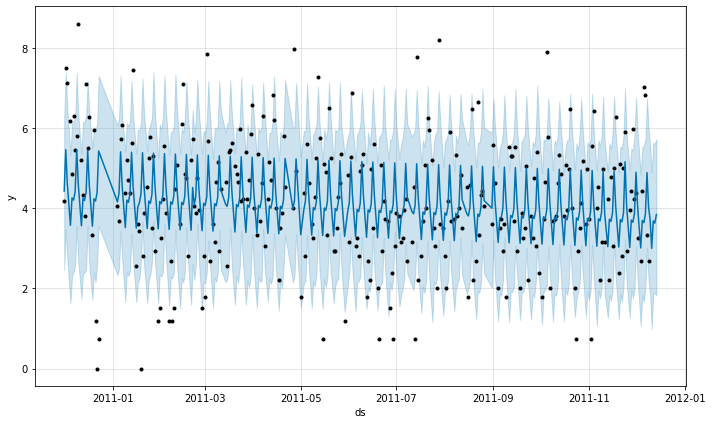

In [138]:
# plot forecast
model.plot(forecast)
pyplot.show()

In [139]:
from scipy.special import inv_boxcox
forecast_df = pd.DataFrame()
forecast_df['ds'] = forecast['ds']
forecast_df[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

model.history['y_t'] = model.history['y']
model.history['y'] = model.history['y_orig']

df1p['y_t'] = df1p['y']
df1p['y'] = df1p['y_orig']

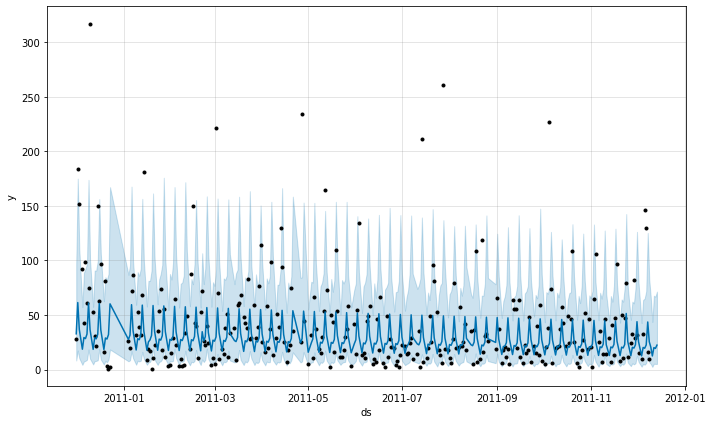

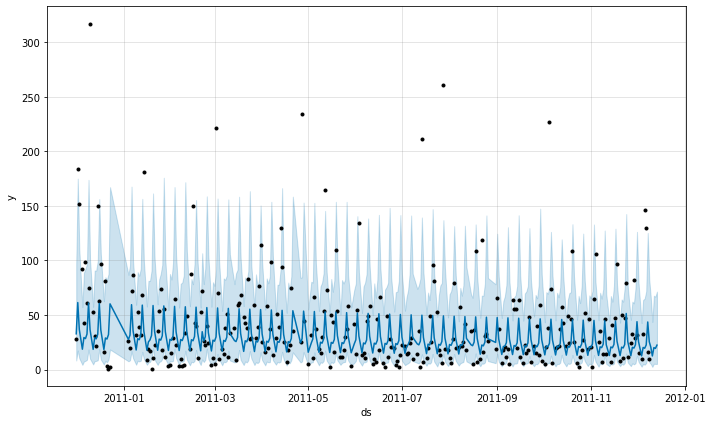

In [140]:
model.plot(forecast_df)

In [141]:
# Evaluate the forecast accuracy / usability based on some predefined performance metrics
metric_df = forecast_df.set_index('ds')[['yhat']].join(df1p.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"r2_score = {r2_score(metric_df.y, metric_df.yhat)}")
print(f"MSE = {mean_squared_error(metric_df.y, metric_df.yhat)}")
print(f"MAE = {mean_absolute_error(metric_df.y, metric_df.yhat)}")

r2_score = 0.03420092177551426
MSE = 1907.6183955223412
MAE = 25.000353484718882


In [142]:
## MAE of 25 indicates that on an average, our daily forecast could be off by 106 sales on either directions

In [143]:
results = forecast_df.tail(17)

In [144]:
results_prophet1 = results[0:-7]
results_prophet1.drop(columns=['yhat_upper','yhat_lower'],inplace = True)


In [145]:
results_prophet1.rename(columns={"ds":'Date', "yhat": "Forecast"},inplace = True)

In [146]:
results_prophet1["Item"] = 'REGENCY CAKESTAND 3 TIER'

In [147]:
#merge with actual sales dataframe
results_prophet1 = pd.merge(df1_sales,results_prophet1,on='Date',how='left').dropna()
results_prophet1

,Date,Quantity,Forecast,Item
288,2011-11-27,24,12.729405,REGENCY CAKESTAND 3 TIER
289,2011-11-28,33,20.474272,REGENCY CAKESTAND 3 TIER
290,2011-11-29,82,19.732692,REGENCY CAKESTAND 3 TIER
291,2011-11-30,29,22.784462,REGENCY CAKESTAND 3 TIER
292,2011-12-01,32,43.945901,REGENCY CAKESTAND 3 TIER
293,2011-12-02,15,25.675723,REGENCY CAKESTAND 3 TIER
294,2011-12-04,10,12.633769,REGENCY CAKESTAND 3 TIER
295,2011-12-05,33,20.329723,REGENCY CAKESTAND 3 TIER
296,2011-12-06,146,19.592704,REGENCY CAKESTAND 3 TIER
297,2011-12-07,130,22.625837,REGENCY CAKESTAND 3 TIER


### PROPHET - Item 2

In [148]:
df_item2 = df.loc[df['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']
df2p = df_item2.groupby(['Date'])['Quantity'].sum().reset_index()
df2p

,Date,Quantity
0,2010-12-02,3264
1,2010-12-03,48
2,2010-12-05,96
3,2010-12-07,48
4,2010-12-08,240
...,...,...
220,2011-12-05,205
221,2011-12-06,240
222,2011-12-07,240
223,2011-12-08,336


In [149]:
df2p['ds'] = df2p['Date']
df2p['y'] = df2p['Quantity']
df2p['ds']= to_datetime(df2p['ds'])

In [150]:
## Since our time series data is not stationary, one nifty workaround is using a box cox transformation to 
# transform the data and then apply our forecasting technique. 

from scipy.stats import boxcox
df2p['y_orig'] = df2p['y']
df2p['y'], lam = boxcox(df2p['y'])

In [151]:
# define the model
model = Prophet()
model.add_country_holidays(country_name = 'US')
# fit the model
model.fit(df2p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [152]:
future = model.make_future_dataframe(periods=5, freq = 'd')

In [153]:
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds      yhat  yhat_lower  yhat_upper
0 2010-12-02  4.434809    3.445568    5.327247
1 2010-12-03  3.878387    2.895934    4.827164
2 2010-12-05  3.874152    2.966669    4.805121
3 2010-12-07  4.085550    3.164140    4.991834
4 2010-12-08  4.147002    3.256615    5.155595


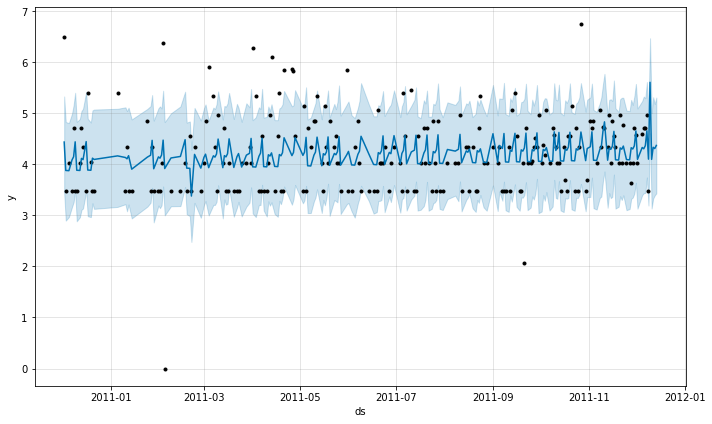

In [154]:
# plot forecast
model.plot(forecast)
pyplot.show()

In [155]:
from scipy.special import inv_boxcox
forecast_df = pd.DataFrame()
forecast_df['ds'] = forecast['ds']
forecast_df[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

model.history['y_t'] = model.history['y']
model.history['y'] = model.history['y_orig']

df2p['y_t'] = df2p['y']
df2p['y'] = df2p['y_orig']

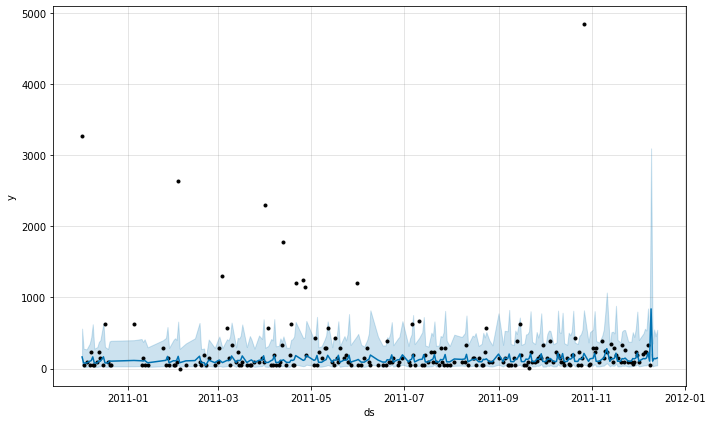

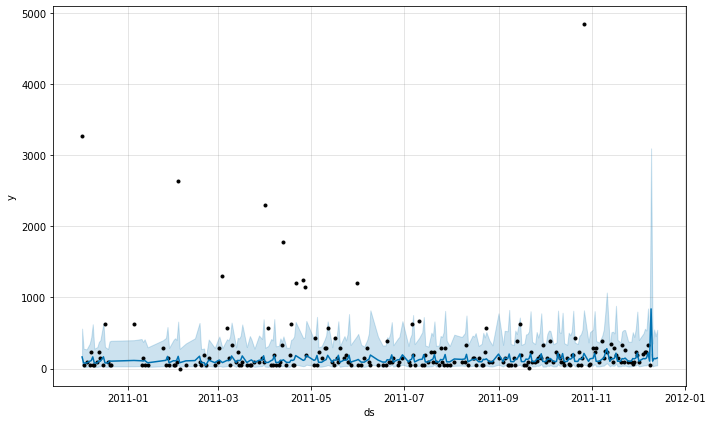

In [156]:
model.plot(forecast_df)

In [157]:
# Evaluate the forecast accuracy / usability based on some predefined performance metrics
metric_df = forecast_df.set_index('ds')[['yhat']].join(df2p.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"r2_score = {r2_score(metric_df.y, metric_df.yhat)}")
print(f"MSE = {mean_squared_error(metric_df.y, metric_df.yhat)}")
print(f"MAE = {mean_absolute_error(metric_df.y, metric_df.yhat)}")

r2_score = -0.03335730029880235
MSE = 244278.22357687505
MAE = 172.45809374207408


In [158]:
## MAE of 172 indicates that on an average, our daily forecast could be off by 106 sales on either directions

In [159]:
results = forecast_df.tail(17)

In [160]:
results_prophet2 = results[0:-7]
results_prophet2.drop(columns=['yhat_upper','yhat_lower'],inplace = True)


In [161]:
results_prophet2.rename(columns={"ds":'Date', "yhat": "Forecast"},inplace = True)

In [162]:
results_prophet2["Item"] = 'WORLD WAR 2 GLIDERS ASSTD DESIGNS'

In [163]:
#merge with actual sales dataframe
results_prophet2 = pd.merge(df2_sales,results_prophet2,on='Date',how='left').dropna()
results_prophet2

,Date,Quantity,Forecast,Item
213,2011-11-25,96,104.558613,WORLD WAR 2 GLIDERS ASSTD DESIGNS
214,2011-11-27,96,103.985201,WORLD WAR 2 GLIDERS ASSTD DESIGNS
215,2011-11-28,58,141.822346,WORLD WAR 2 GLIDERS ASSTD DESIGNS
216,2011-11-29,96,137.123879,WORLD WAR 2 GLIDERS ASSTD DESIGNS
217,2011-11-30,240,148.727355,WORLD WAR 2 GLIDERS ASSTD DESIGNS
218,2011-12-01,198,219.912520,WORLD WAR 2 GLIDERS ASSTD DESIGNS
219,2011-12-02,96,105.127725,WORLD WAR 2 GLIDERS ASSTD DESIGNS
220,2011-12-05,205,142.607672,WORLD WAR 2 GLIDERS ASSTD DESIGNS
221,2011-12-06,240,137.881746,WORLD WAR 2 GLIDERS ASSTD DESIGNS
222,2011-12-07,240,149.553128,WORLD WAR 2 GLIDERS ASSTD DESIGNS


### PROPHET - Item 3

In [164]:
df_item3 = df.loc[df['Description']=='JUMBO BAG RED RETROSPOT']
df3p = df_item3.groupby(['Date'])['Quantity'].sum().reset_index()
df3p

,Date,Quantity
0,2010-12-01,554
1,2010-12-02,48
2,2010-12-03,43
3,2010-12-05,39
4,2010-12-06,149
...,...,...
291,2011-12-05,50
292,2011-12-06,174
293,2011-12-07,80
294,2011-12-08,92


In [165]:
df3p['ds'] = df3p['Date']
df3p['y'] = df3p['Quantity']
df3p['ds']= to_datetime(df3p['ds'])

In [166]:
## Since our time series data is not stationary, one nifty workaround is using a box cox transformation to 
# transform the data and then apply our forecasting technique. 

from scipy.stats import boxcox
df3p['y_orig'] = df3p['y']
df3p['y'], lam = boxcox(df3p['y'])

In [167]:
# define the model
model = Prophet()
model.add_country_holidays(country_name = 'US')
# fit the model
model.fit(df3p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [168]:
future = model.make_future_dataframe(periods=5, freq = 'd')

In [169]:
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds      yhat  yhat_lower  yhat_upper
0 2010-12-01  6.600312    3.849937    9.449776
1 2010-12-02  6.580800    3.790982    9.403546
2 2010-12-03  5.821383    2.934691    8.615724
3 2010-12-05  4.095649    1.337523    6.924792
4 2010-12-06  6.472347    3.568130    9.335836


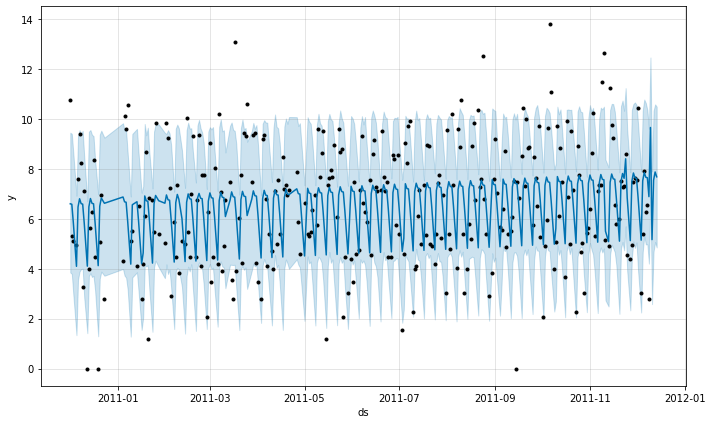

In [170]:
# plot forecast
model.plot(forecast)
pyplot.show()

In [171]:
from scipy.special import inv_boxcox
forecast_df = pd.DataFrame()
forecast_df['ds'] = forecast['ds']
forecast_df[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

model.history['y_t'] = model.history['y']
model.history['y'] = model.history['y_orig']

df3p['y_t'] = df3p['y']
df3p['y'] = df3p['y_orig']

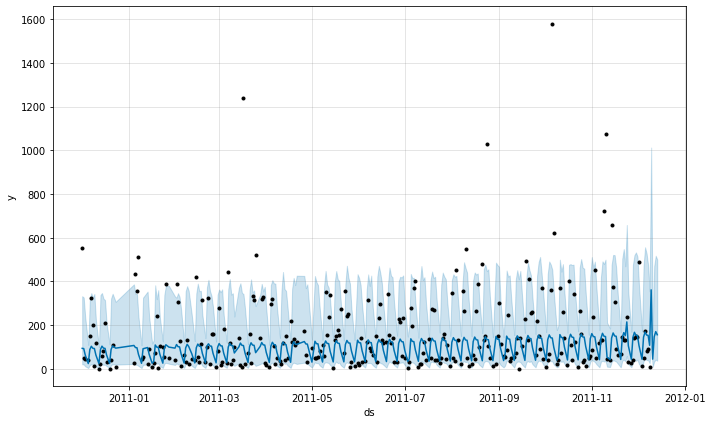

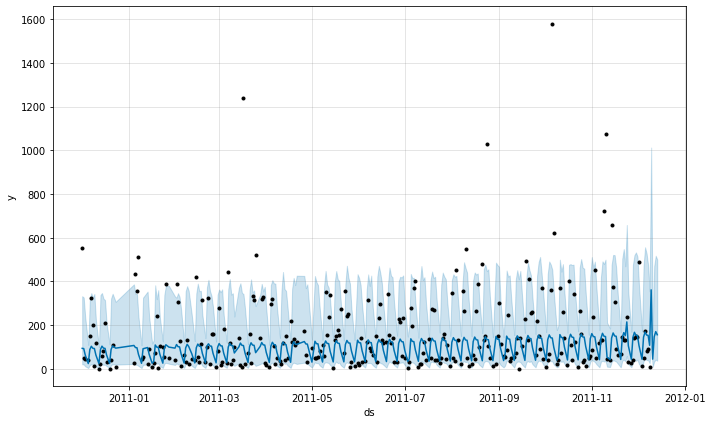

In [172]:
model.plot(forecast_df)

In [173]:
# Evaluate the forecast accuracy / usability based on some predefined performance metrics
metric_df = forecast_df.set_index('ds')[['yhat']].join(df3p.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"r2_score = {r2_score(metric_df.y, metric_df.yhat)}")
print(f"MSE = {mean_squared_error(metric_df.y, metric_df.yhat)}")
print(f"MAE = {mean_absolute_error(metric_df.y, metric_df.yhat)}")

r2_score = -0.00839892865697811
MSE = 35646.81667146322
MAE = 106.04939460481278


In [174]:
## MAE of 106 indicates that on an average, our daily forecast could be off by 106 sales on either directions

In [175]:
results = forecast_df.tail(17)

In [176]:
results_prophet3 = results[0:-7]
results_prophet3.drop(columns=['yhat_upper','yhat_lower'],inplace = True)


In [177]:
results_prophet3.rename(columns={"ds":'Date', "yhat": "Forecast"},inplace = True)

In [178]:
results_prophet3["Item"] = 'JUMBO BAG RED RETROSPOT'

In [179]:
results_prophet3

,Date,Forecast,Item
284,2011-11-27,43.174087,JUMBO BAG RED RETROSPOT
285,2011-11-28,143.595134,JUMBO BAG RED RETROSPOT
286,2011-11-29,166.962243,JUMBO BAG RED RETROSPOT
287,2011-11-30,152.971260,JUMBO BAG RED RETROSPOT
288,2011-12-01,151.759345,JUMBO BAG RED RETROSPOT
289,2011-12-02,106.350648,JUMBO BAG RED RETROSPOT
290,2011-12-04,43.667064,JUMBO BAG RED RETROSPOT
291,2011-12-05,144.953262,JUMBO BAG RED RETROSPOT
292,2011-12-06,168.504516,JUMBO BAG RED RETROSPOT
293,2011-12-07,154.403801,JUMBO BAG RED RETROSPOT


In [180]:
#merge with actual sales dataframe
results_prophet3 = pd.merge(df3_sales,results_prophet3,on='Date',how='left').dropna()

In [181]:
results_prophet3

,Date,Quantity,Forecast,Item
284,2011-11-27,28,43.174087,JUMBO BAG RED RETROSPOT
285,2011-11-28,39,143.595134,JUMBO BAG RED RETROSPOT
286,2011-11-29,141,166.962243,JUMBO BAG RED RETROSPOT
287,2011-11-30,152,152.971260,JUMBO BAG RED RETROSPOT
288,2011-12-01,147,151.759345,JUMBO BAG RED RETROSPOT
289,2011-12-02,490,106.350648,JUMBO BAG RED RETROSPOT
290,2011-12-04,12,43.667064,JUMBO BAG RED RETROSPOT
291,2011-12-05,50,144.953262,JUMBO BAG RED RETROSPOT
292,2011-12-06,174,168.504516,JUMBO BAG RED RETROSPOT
293,2011-12-07,80,154.403801,JUMBO BAG RED RETROSPOT


In [185]:
pdList = [results_prophet1, results_prophet2, results_prophet3]  
new_df = pd.concat(pdList)
new_df.to_csv("../data/prophet_results.csv", index=None)

In [186]:
new_df

,Date,Quantity,Forecast,Item
288,2011-11-27,24,12.729405,REGENCY CAKESTAND 3 TIER
289,2011-11-28,33,20.474272,REGENCY CAKESTAND 3 TIER
290,2011-11-29,82,19.732692,REGENCY CAKESTAND 3 TIER
291,2011-11-30,29,22.784462,REGENCY CAKESTAND 3 TIER
292,2011-12-01,32,43.945901,REGENCY CAKESTAND 3 TIER
293,2011-12-02,15,25.675723,REGENCY CAKESTAND 3 TIER
294,2011-12-04,10,12.633769,REGENCY CAKESTAND 3 TIER
295,2011-12-05,33,20.329723,REGENCY CAKESTAND 3 TIER
296,2011-12-06,146,19.592704,REGENCY CAKESTAND 3 TIER
297,2011-12-07,130,22.625837,REGENCY CAKESTAND 3 TIER


In [208]:
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=new_df['Date'],
        y=new_df['Quantity'],
        name='actual',
        line_color = 'darkturquoise'
    ),
        go.Scatter(
        x=new_df['Date'],
        y=new_df['Forecast'],
        name='predicted'
    )
    
]

plot_layout = go.Layout(
        title='Sales Forecast'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### Final result plot for Prophet model

In [223]:
fig = px.line(new_df, x="Date", y="Forecast", color='Item', color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()

### Final result plot for LSTM model

In [225]:
fig = px.line(lstm_df, x="Date", y="Pred_value", color='Item', color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()